<a href="https://colab.research.google.com/github/khm9888/projects/blob/main/1_3_1_image_cls_resnet_sota_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **classiffication_transfer_image**




cifar10 가져와서 sota 모델 전이학습





In [1]:
!pip install vit-pytorch

In [2]:
#0.라이브러리 임포트
#1.데이터
#2.모델구성
#3.훈련 및 검증
#4.평가 및 예측
#5.시각화


In [3]:
#0.라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
%matplotlib inline
#이건 왜 하는가? 에러 안 나기 위해서 정도로 알고 있음
from matplotlib import pyplot as plt
import pandas as pd
# from tqdm import tqdm
from tqdm.notebook import tqdm
import time
import os
import copy


#기억 안 나는 것들.

from vit_pytorch import ViT
#vit(sota 모델을 위해 추가)
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler    
# from sklearn.model_selection import train_test_split

import seaborn as sns
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

plt.ion() # interactive mode


In [4]:
t= torch.cuda.is_available()
device =torch.device("cuda" if t else "cpu")
print(t)

True


In [5]:
torch.manual_seed(1)

In [6]:
#1.데이터

#co-lab에서는 데이터 다시 넣어줘야함.


batch_size = 64

data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # transforms.Resize(32),
        # transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
trainset = datasets.CIFAR10(root="./data",train=True,download=True,
                                 transform=data_transforms["train"])

valset = datasets.CIFAR10(root="./data",train=False,download=True,
                                 transform=data_transforms["val"])

image_datasets = {'train': trainset, 'val':valset}


# trainloader = DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=4)

# testloader = DataLoader(valset, batch_size=batch_size,
#                                          shuffle=False, num_workers=4)

dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=2)
                for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')




Files already downloaded and verified
Files already downloaded and verified


In [7]:
def imshow(img): 
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


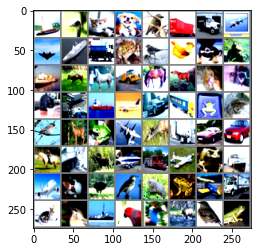

 ship  bird   cat   dog  bird truck truck plane plane  ship truck  frog  bird  bird   dog  frog  ship  deer horse truck horse horse   dog   cat   cat truck  ship plane   car truck  frog  frog  bird  deer  frog plane  deer truck   car   car horse   cat  deer  ship truck plane  frog  ship plane   cat  bird  bird  frog  frog plane truck   cat  bird  ship  bird  bird  deer  bird  frog
torch.Size([3, 32, 32])


In [8]:
# 학습용 이미지를 무작위로 가져오기
dataiter = iter(dataloaders["train"])
images, labels = dataiter.next()
# print(images, labels)
# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

print(images[0].size())# torch.Size([3, 32, 32])

In [9]:
#2.모델구성

# model= ViT(
#     image_size = 256,
#     patch_size = 32,
#     num_classes = 1000,
#     dim = 1024,
#     depth = 6,
#     heads = 16,
#     mlp_dim = 2048,
#     dropout = 0.1,
#     emb_dropout = 0.1
# ).to(device)

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 10)

model = model_ft.to(device)



# SGD의 optimizer상에서 정의한 네트워크의 
# 파라미터를 전달해서 초기화

# LEARNING_RATE = 0.001 #1e-3

optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# MSE loss클래스
loss_fn = nn.CrossEntropyLoss()
#loss_fn = F.mse_loss #F쪽에 있는 loss_fn을 써도 무방하다.

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [10]:
#https://9bow.github.io/PyTorch-tutorials-kr-0.3.1/beginner/transfer_learning_tutorial.html#finetuning
#에서 가져온 것이니 추후 train_model에 대한 추가 분석 필요

def train_model(model, criterion, optimizer,scheduler, num_epochs):
    since = time.time()
    last_epoch=0
    loss_stats = {"train":[],"val":[]}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_valid_loss = np.inf

    for epoch in tqdm(range(1,num_epochs+1)):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if t:
                    inputs = Variable(inputs.cuda())#이것도 신기하네..
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)


                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()
                # print("outputs")
                # print(outputs)
                # print("preds")
                # print(preds)
                # print("labels")
                # print(labels)
                # print("loss")
                # print(loss)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            if phase=="train":
                loss_stats["train"].append(epoch_loss)
            else:
                loss_stats["val"].append(epoch_loss)

            print(f'epoch : {epoch} phase : {phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                print(f'Accuracy Increased({best_acc:.6f}--->{epoch_acc:.6f}) \t Saving The Model')
                best_model_wts = copy.deepcopy(model.state_dict())
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'acc_saved_model.pth')
                last_epoch=epoch

            if phase == 'val'  and min_valid_loss > epoch_loss:
                print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{epoch_loss:.6f}) \t Saving The Model')
                min_valid_loss = epoch_loss
                # Saving State Dict
                torch.save(model.state_dict(), 'loss_saved_model.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,loss_stats,last_epoch

In [11]:
#3.훈련 및 검증

# loss_stats = {"train":[],"valid":[]}

epochs = 50


model,loss_stats,last_epoch = train_model(model, loss_fn, optimizer,exp_lr_scheduler,epochs)
print("last_epoch")
print(last_epoch)

In [ ]:
# 모델의 state_dict 출력
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor)
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    print("-"*100)

print()
# 옵티마이저의 state_dict 출력
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name)
    print(var_name, "\t", optimizer.state_dict()[var_name])
    print("-"*100)

In [ ]:
# # 경로 지정
# PATH = "state_dict_model.pt"

# # 저장하기
# torch.save(model.state_dict(), PATH)

# # 불러오기
# model = Multivariate_LinearRegressionModel()
# model.load_state_dict(torch.load(PATH))
# v=model.eval()
# print(v)

# #5. 전체 모델을 저장하고 불러오기

# # 경로 지정
# PATH = "entire_model.pt"

# # 저장하기
# torch.save(model, PATH)

# # 불러오기
# model = torch.load(PATH)
# v=model.eval()
# print(v)


# model.eval()
# # - 또는 -
# model.train()

In [ ]:
#4.평가 및 예측

# PATH = "acc_saved_model.pt"
PATH = "/content/acc_saved_model.pth"

model = models.resnet18()
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 10)

model = model_ft.to(device)

with torch.no_grad():
    model.eval()
    running_loss=0
    corrects=0

    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    for data in dataloaders["val"]:
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        if t:
            inputs = Variable(inputs.cuda())#이것도 신기하네..
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)


        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        loss = loss_fn(outputs, labels)

        for label, prediction in zip(labels, preds):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

        running_loss += loss.item() * inputs.size(0)
        corrects += torch.sum(preds == labels.data)

        # dataiter = iter(dataloaders["val"])
        # images, labels = dataiter.next()
        # images, labels = images.float(), labels.float()
        # y_predict = model(images)

        preds = preds.to("cpu").detach().numpy().reshape(preds.size()[0])
        labels = labels.to("cpu").detach().numpy().reshape(labels.size()[0])

epoch_loss = running_loss / dataset_sizes["val"]
epoch_acc = corrects / dataset_sizes["val"]

print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc*100:.4f}%')

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class {classname:5s} is: {accuracy:.1f} %")


In [ ]:
#5.시각화

train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')


# plt.plot(train_losses[50::20])
# plt.plot(valid_losses[50::20])